In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using MCMCDiagnostics

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
@load "../data/sim2data.jld";

In [5]:
# priors #
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

In [6]:
x_1 = X_ord[S1_ind, :]; x_2 = X_ord[S2_ind, :]; 
y_1 = Y_ord[S1_ind, 1]; y_2 = Y_ord[S2_ind, 2]; 
coords_1 = coords_ord[S1_ind, :]; coords_2 = coords_ord[S2_ind, :]; 
P1_ind = setdiff(1:N, S1_ind);
P2_ind = setdiff(1:N, S2_ind);
coords_ord_P1 = coords_ord[P1_ind, :];
coords_ord_P2 = coords_ord[P2_ind, :];

In [7]:
using RCall
@rput x_1 x_2 y_1 y_2 X_ord;
@rput q p K;
@rput ϕU ϕL;
@rput coords_1 coords_2 coords_ord_P1 coords_ord_P2 P1_ind P2_ind


R"""
library(spBayes)
set.seed(1)
n.samples <- 10000
A.starting <- diag(1, q)[lower.tri(diag(1,q), TRUE)]
starting <- list("phi"=rep(3/0.5,q), "A"=A.starting, "Psi"=rep(1,q))
tuning <- list("phi"=rep(0.1,q), "A"=rep(0.01,length(A.starting)), "Psi"=rep(0.01,q))
priors <- list("beta.Flat", "phi.Unif"=list(rep(ϕL, q), rep(ϕU, q)),
               "K.IW"=list(q + 1, diag(1.0, q)), "Psi.ig"=list(rep(2 , q), rep(0.5, q)))
t <- proc.time()
m.1 <- spMisalignLM(list(y_1~x_1-1, y_2~x_2-1), 
                    coords = list(coords_1, coords_2), starting=starting, tuning=tuning, priors=priors,
                    n.samples=n.samples, cov.model="exponential", n.report=100)
burn.in <- 0.75*n.samples

m.1 <- spRecover(m.1, start = burn.in)

print(proc.time()-t)

print(round(summary(m.1$p.theta.recover.samples)$quantiles[,c(3,1,5)],2))
print(round(summary(m.1$p.beta.recover.samples)$quantiles[,c(3,1,5)],2))
theta_samples_all <- m.1$p.theta.samples
theta_samples <- m.1$p.theta.recover.samples
beta_samples <- m.1$p.beta.recover.samples
w_samples <- m.1$p.w.recover.samples
cat(m.1$run.time)

t <- proc.time()
# predict for all locations, i.e., observed and not observed
out <- spPredict(m.1, start = burn.in, thin = 1, pred.covars = list(X_ord[P1_ind, ], X_ord[P2_ind, ]),
                pred.coords = list(coords_ord_P1, coords_ord_P2))
cat("\n", proc.time() - t)
mean_quants <- function(x){c(mean(x), quantile(x, prob=c(0.5, 0.025, 0.975)))}
yhat <- apply(out$p.y.predictive.samples, 1, mean_quants)
m1_w_hat <- summary(mcmc(t(m.1$p.w.recover.samples)))$quantiles[,c(3,1,5)]


# size for the mapping of w               
width <- 360*3
height <- 360*3
pointsize <- 16

png(paste("../../pics/MCMC_sim4_spBayes.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
plot(m.1$p.theta.samples)
dev.off()

"""
@rget theta_samples_all
@rget theta_samples
@rget beta_samples
@rget yhat
@rget m1_w_hat
@rget w_samples

┌ Warning: RCall.jl: Loading required package: coda
│ Loading required package: magic
│ Loading required package: abind
│ Loading required package: Formula
│ Loading required package: Matrix
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


----------------------------------------
	General model description
----------------------------------------
Model fit with 2 outcome variables.

Number of observations within each outcome: 1000 1000 

Number of covariates for each outcome (including intercept if specified): 2 2 

Total number of observations: 2000

Total number of covariates (including intercept if specified): 4

Using the exponential spatial correlation model.

Number of MCMC samples 10000.

Priors and hyperpriors:
	beta flat.

	K IW hyperpriors df=3.00000, S=
	1.000	0.000	
	0.000	1.000	

	Diag(Psi) IG hyperpriors
		parameter	shape	scale
		Psi[1,1]	2.0	0.50
		Psi[2,2]	2.0	0.50

	phi Unif hyperpriors
		parameter	a	b
		phi[1]		2.12132	212.13203
		phi[2]		2.12132	212.13203

-------------------------------------------------
		Sampling
-------------------------------------------------
Sampled: 100 of 10000, 1.00%
Report interval Metrop. Acceptance rate: 36.00%
Overall Metrop. Acceptance rate: 36.00%
----------------------

Sampled: 4500 of 10000, 45.00%
Report interval Metrop. Acceptance rate: 3.00%
Overall Metrop. Acceptance rate: 5.71%
-------------------------------------------------
Sampled: 4600 of 10000, 46.00%
Report interval Metrop. Acceptance rate: 7.00%
Overall Metrop. Acceptance rate: 5.74%
-------------------------------------------------
Sampled: 4700 of 10000, 47.00%
Report interval Metrop. Acceptance rate: 2.00%
Overall Metrop. Acceptance rate: 5.66%
-------------------------------------------------
Sampled: 4800 of 10000, 48.00%
Report interval Metrop. Acceptance rate: 6.00%
Overall Metrop. Acceptance rate: 5.67%
-------------------------------------------------
Sampled: 4900 of 10000, 49.00%
Report interval Metrop. Acceptance rate: 12.00%
Overall Metrop. Acceptance rate: 5.80%
-------------------------------------------------
Sampled: 5000 of 10000, 50.00%
Report interval Metrop. Acceptance rate: 12.00%
Overall Metrop. Acceptance rate: 5.92%
----------------------------------------------

Sampled: 9500 of 10000, 95.00%
Report interval Metrop. Acceptance rate: 6.00%
Overall Metrop. Acceptance rate: 5.45%
-------------------------------------------------
Sampled: 9600 of 10000, 96.00%
Report interval Metrop. Acceptance rate: 3.00%
Overall Metrop. Acceptance rate: 5.43%
-------------------------------------------------
Sampled: 9700 of 10000, 97.00%
Report interval Metrop. Acceptance rate: 5.00%
Overall Metrop. Acceptance rate: 5.42%
-------------------------------------------------
Sampled: 9800 of 10000, 98.00%
Report interval Metrop. Acceptance rate: 2.00%
Overall Metrop. Acceptance rate: 5.39%
-------------------------------------------------
Sampled: 9900 of 10000, 99.00%
Report interval Metrop. Acceptance rate: 3.00%
Overall Metrop. Acceptance rate: 5.36%
-------------------------------------------------
Sampled: 10000 of 10000, 100.00%
Report interval Metrop. Acceptance rate: 4.00%
Overall Metrop. Acceptance rate: 5.35%
----------------------------------------------

2000×2501 Array{Float64,2}:
 -0.416893   -0.0264758  -1.16429    …   0.0725867   0.588997   -0.45098 
  1.7025      1.9472      1.46937        2.31262     2.08283     2.24897 
  0.210079   -0.0594723  -0.551691       0.530275   -0.19302     0.836332
 -1.27798    -0.806958   -1.66867       -0.182258   -0.0432639  -0.578617
 -1.18517    -0.224923   -1.17098        0.364769    0.0322412  -0.388624
 -1.49077    -1.1977     -2.28158    …  -0.753696   -0.723861   -0.945303
  0.374704   -0.139592   -0.337789       0.333748    0.522446    0.188148
  0.331221    0.935456    0.303885       1.20799     1.80371     1.04869 
  0.329054    0.677917    0.462155       1.19667     0.711935    0.643662
  0.406028   -0.19608    -1.04859        0.204573    0.196494    0.109498
  0.229772    0.402042   -0.295826   …   0.465886    0.931631    0.194746
  0.757387   -0.0934331   0.0244597      0.634523    0.546027    0.478103
 -0.910929   -1.0769     -1.45316       -0.38117     0.0138     -0.636318
  ⋮       

In [8]:
ω_incp_samples = Array{Float64, 2}(undef, size(w_samples));
N_sam = size(w_samples)[2]
for i in 1:N_sam
    for j in 1:q
        ω_incp_samples[(1 + (j - 1) * N1):(j * N1), i] = 
        w_samples[(1 + (j - 1) * N1):(j * N1), i] .+ beta_samples[i, 1 + (j - 1) * q]
    end
end

ω_incp_qt = Array{Float64, 3}(undef, N1, q, 3);
for j in 1:q
    for i in 1:N1
        ω_incp_qt[i, j, :] = quantile(ω_incp_samples[i + (j - 1) * N1, :], [0.025, 0.5, 0.975])
    end
end
ω_incp_mean = Array{Float64, 2}(undef, N1, q);
for j in 1:q
    for i in 1:N1
        ω_incp_mean[i, j] = mean(ω_incp_samples[i + (j - 1) * N1, :])
    end
end

In [9]:
@save "../results/LMC_misalign_spbayes.jld" theta_samples beta_samples yhat ω_incp_samples w_samples ω_incp_qt theta_samples_all

In [10]:
@save "../results/w_incp_mean_benchmark.jld" ω_incp_mean 

# MCMC Chain check

In [7]:
@load "../results/LMC_misalign_spbayes.jld"

7-element Array{Symbol,1}:
 :theta_samples    
 :beta_samples     
 :yhat             
 :ω_incp_samples   
 :w_samples        
 :ω_incp_qt        
 :theta_samples_all

In [8]:
@load "../results/w_incp_mean_benchmark.jld"

1-element Array{Symbol,1}:
 :ω_incp_mean

In [9]:
N_sam = size(w_samples)[2]
ω_qt = Array{Float64, 3}(undef, N1, q, 3);
for j in 1:q
    for i in 1:N1
        ω_qt[i, j, :] = quantile(w_samples[i + (j - 1) * N1, :], [0.025, 0.5, 0.975])
    end
end
ω_mean = Array{Float64, 2}(undef, N1, q);
for j in 1:q
    for i in 1:N1
        ω_mean[i, j] = mean(w_samples[i + (j - 1) * N1, :])
    end
end

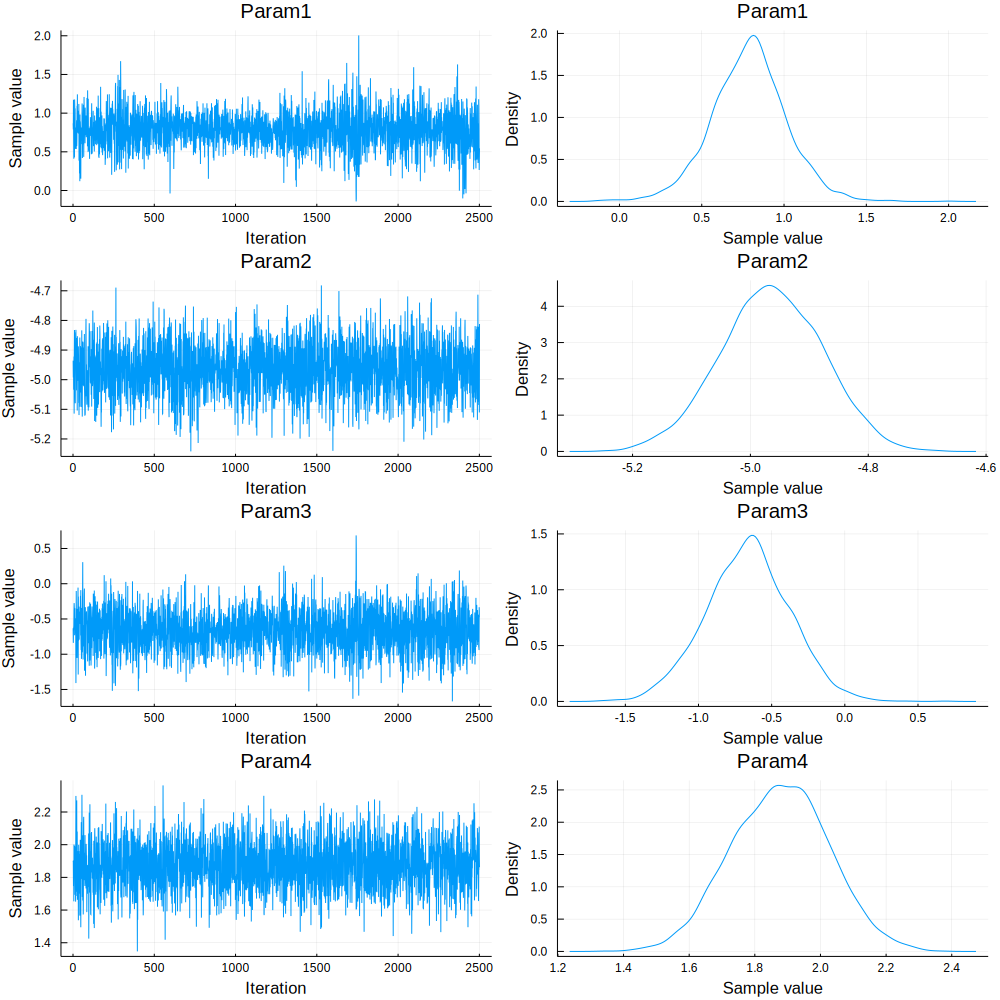

In [10]:
β_pos_sam = Array{Float64, 3}(undef, size(beta_samples)[1], p * q, 1);
β_pos_sam[:, :, 1] = hcat(beta_samples[:, 1], beta_samples[:, 2], beta_samples[:, 3], beta_samples[:, 4]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [11]:
β

2×2 Array{Float64,2}:
  1.0  -1.0
 -5.0   2.0

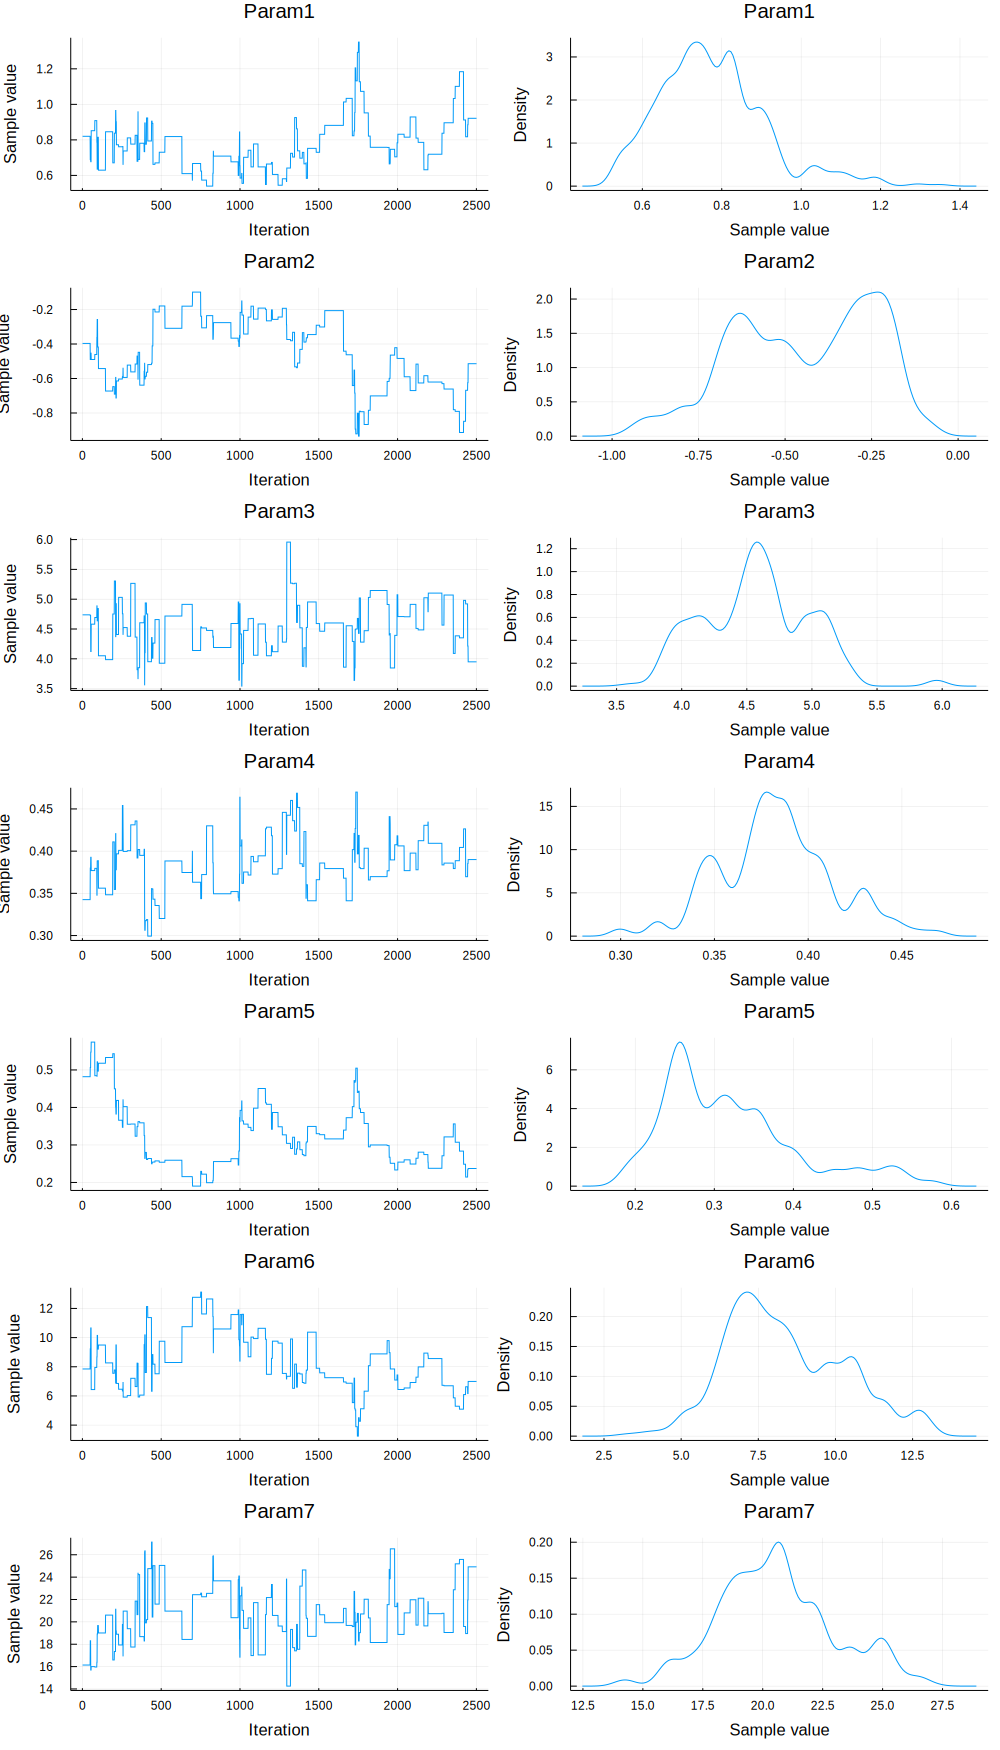

In [12]:
Λ_pos_sam = Array{Float64, 3}(undef, size(theta_samples)[1], size(theta_samples)[2], 1);
Λ_pos_sam[:, :, 1] = hcat(theta_samples[:, 1], theta_samples[:, 2], theta_samples[:, 3], theta_samples[:, 4],
    theta_samples[:, 5], theta_samples[:, 6], theta_samples[:, 7]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

In [13]:
Λ

2×2 Array{Float64,2}:
 1.0  -1.0
 0.0   2.0

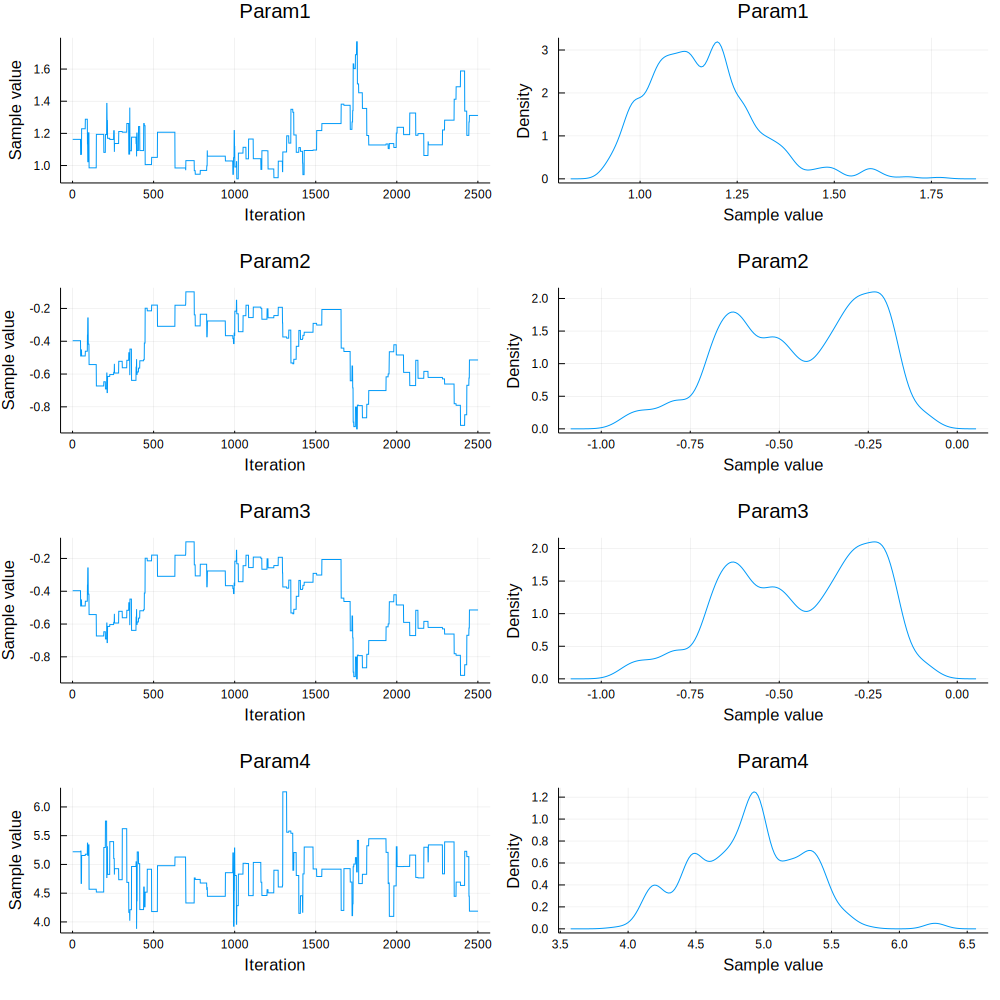

In [14]:
Ω_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
for i in 1:(N_sam)
    ΛTΛ_temp = [theta_samples[i, 1] theta_samples[i, 2]
        theta_samples[i, 2] theta_samples[i, 3]]
    Ω_pos_sam[i, :, 1] = vec(ΛTΛ_temp)
    Ω_pos_sam[i, 1, 1] = Ω_pos_sam[i, 1, 1] + theta_samples[i, 4];
    Ω_pos_sam[i, 4, 1] = Ω_pos_sam[i, 4, 1] + theta_samples[i, 5];
end
Ω_chain = Chains(Ω_pos_sam)
pΩ = plot(Ω_chain)

In [15]:
Ω = Λ'Λ +Σ

2×2 Array{Float64,2}:
  1.4   -0.85
 -0.85   5.3 

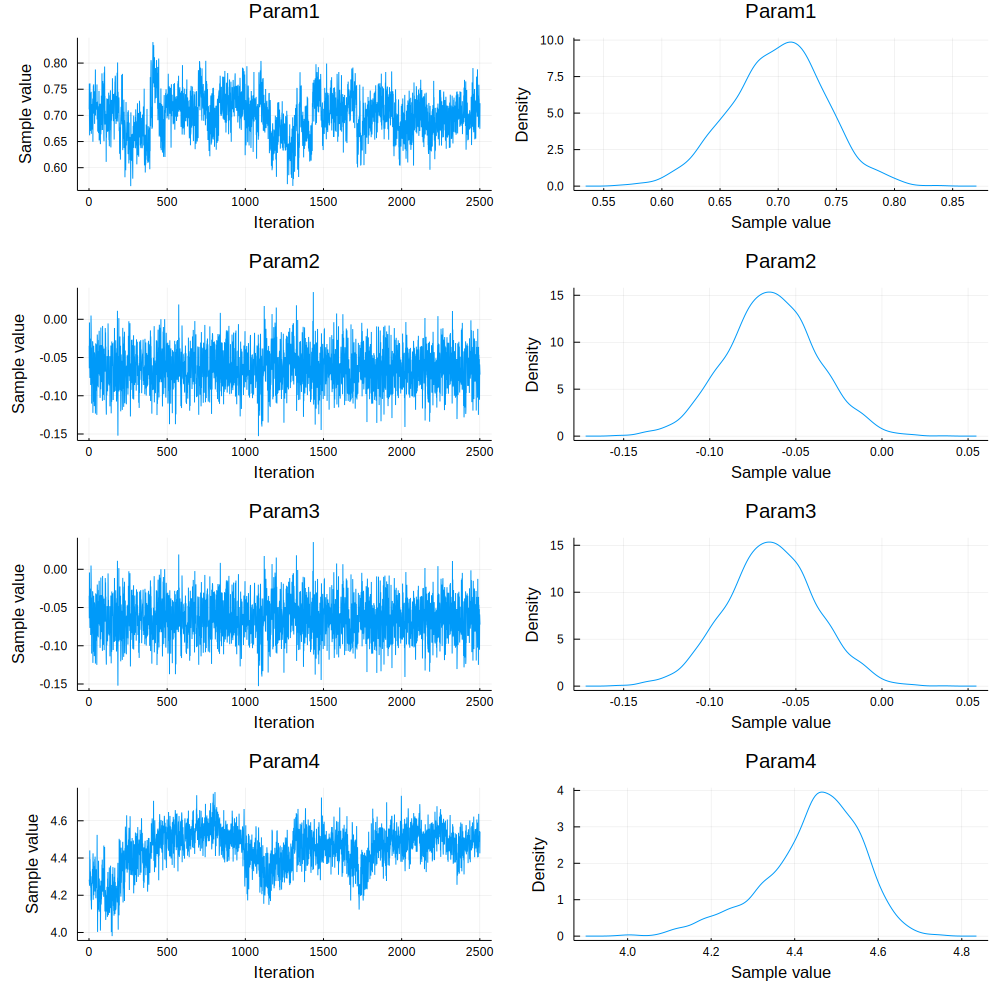

In [16]:
# check the variance covariance across latent process
N_sam = size(w_samples)[2]
cov_pos = Array{Float64, 3}(undef, q, q, N_sam);
for i in 1:N_sam
    cov_pos[:, :, i] = cov([w_samples[1:N1, i] w_samples[(1 + N1):(2 * N1), i]])
end   
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
    cov_pos[2, 1, :], cov_pos[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

# Posterior Inference 

In [17]:
# CVG and RMSPE#
Nm = N - N1
count = fill(0.0, 2);
SPE = fill(0.0, 2)

for i in 1:Nm
    count[1] = count[1] + 
            ((yhat[3, i] < Y_ord[P1_ind[i], 1]) && 
                (yhat[4, i] > Y_ord[P1_ind[i], 1]))
    SPE[1] = SPE[1] + (yhat[1, i] - Y_ord[P1_ind[i], 1])^2
end

for i in 1:Nm
    count[2] = count[2] + 
            ((yhat[3, i + Nm] < Y_ord[P2_ind[i], 2]) && 
                (yhat[4, i + Nm] > Y_ord[P2_ind[i], 2]))
    SPE[2] = SPE[2] + (yhat[1, i + Nm] - Y_ord[P2_ind[i], 2])^2
end
print(count ./ 200);
print(sum(count) / 400);

[0.96, 0.95]0.955

In [18]:
print(round.(sqrt.(SPE ./ 200), digits = 3));
print(round(sqrt(sum(SPE) / 400), digits = 3));

[0.729, 1.368]1.096

In [19]:
# CVGL latent process#
count = fill(0.0, 2);
SPEL = fill(0.0, 2)
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((ω_qt[i, j, 1 ] < ω_ord[S1_ind[i], j]) && 
                (ω_qt[i, j, 3 ] > ω_ord[S1_ind[i], j]));
            SPEL[1] = SPEL[1] + (ω_mean[i, j] - ω_ord[S1_ind[i], j])^2;
        else
            count[2] = count[2] + 
                ((ω_qt[i, j, 1] < ω_ord[S2_ind[i], j]) && 
                (ω_qt[i, j, 3] > ω_ord[S2_ind[i], j]));
            SPEL[2] = SPEL[2] + (ω_mean[i, j] - ω_ord[S2_ind[i], j])^2;
        end
    end
end
print(round.(count ./ N, digits = 3));
print(round(sum(count) / (2*N), digits = 3))

[0.792, 0.807]0.8

In [20]:
# CVGL intercept-centered latent process#
count = fill(0.0, 2);
SPEL = fill(0.0, 2)
for j in 1:q
    for i in 1:N1
        if j == 1
            count[1] = count[1] + 
                ((ω_incp_qt[i, j, 1 ] < ω_incp_obs[S1_ind[i], j]) && 
                (ω_incp_qt[i, j, 3 ] > ω_incp_obs[S1_ind[i], j]));
            SPEL[1] = SPEL[1] + (ω_incp_mean[i, j] - ω_incp_obs[S1_ind[i], j])^2;
        else
            count[2] = count[2] + 
                ((ω_incp_qt[i, j, 1] < ω_incp_obs[S2_ind[i], j]) && 
                (ω_incp_qt[i, j, 3] > ω_incp_obs[S2_ind[i], j]));
            SPEL[2] = SPEL[2] + (ω_incp_mean[i, j] - ω_incp_obs[S2_ind[i], j])^2;
        end
    end
end
print(round.(count ./ N, digits = 3));
print(round(sum(count) / (2*N), digits = 3))

[0.792, 0.81]0.801

In [21]:
# MSEL #
print(round.((SPEL ./ N1), digits = 3));
print(round((sum(SPEL) / (2 * N1)), digits = 3));

[0.133, 0.218]0.176

In [22]:
Y_P1_sam_std = (yhat[4, 1:200] .- yhat[3, 1:200]) ./ (2*1.96);
Y_P2_sam_std = (yhat[4, 201:400] .- yhat[3, 201:400]) ./ (2*1.96);

In [23]:
# CRPS #
CRPS_P1 = [(Y_P1_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) -
        ((Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) * 
        (2* cdf(Normal(), (Y_ord[P1_ind[i], 1] - yhat[1, i]) / Y_P1_sam_std[i]) - 1 )))
        for i in 1:length(P1_ind)];
CRPS_P2 = [(Y_P2_sam_std[i] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) -
        ((Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) * 
        (2* cdf(Normal(), (Y_ord[P2_ind[i], 2] - yhat[1, i + 200]) / Y_P2_sam_std[i]) - 1 )))
        for i in 1:length(P2_ind)];

CRPS1 = sum(CRPS_P1) / length(P1_ind);
CRPS2 = sum(CRPS_P2) / length(P2_ind);
CRPS = (sum(CRPS_P1) + sum(CRPS_P2)) / (length(P1_ind) + length(P2_ind))
round.([CRPS1 CRPS2 CRPS], digits = 3)

1×3 Array{Float64,2}:
 -0.413  -0.762  -0.588

In [24]:
ω_incp_sam_std = [(ω_incp_qt[i, j, 3] - ω_incp_qt[i, j, 1]) ./ (2*1.96) 
    for i in 1:1000, j in 1:2];

In [25]:
# CRPSL over observed locations#

CRPSL_S1 = [(ω_incp_sam_std[i, 1] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) -
        ((ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) * 
        (2* cdf(Normal(), (ω_incp_obs[S1_ind[i], 1] - ω_incp_mean[i, 1]) / ω_incp_sam_std[i, 1]) - 1)))
        for i in 1:length(S1_ind)];

CRPSL_S2 = [(ω_incp_sam_std[i, 2] * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) -
        ((ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) * 
        (2* cdf(Normal(), (ω_incp_obs[S2_ind[i], 2] - ω_incp_mean[i, 2]) / ω_incp_sam_std[i, 2]) - 1)))
        for i in 1:length(S2_ind)];


CRPSL1 = sum(CRPSL_S1) / length(S1_ind);
CRPSL2 = sum(CRPSL_S2) / length(S2_ind);
CRPSL = (sum(CRPSL_S1) + sum(CRPSL_S2)) / (length(S1_ind) + length(S2_ind))
round.([CRPSL1 CRPSL2 CRPSL], digits = 3)

1×3 Array{Float64,2}:
 -0.206  -0.265  -0.235

In [26]:
# INT #
INT_1 = [((2 * 1.96 * Y_P1_sam_std[i]) + 
                (2 / 0.05)*(yhat[1, i] - 1.96 * Y_P1_sam_std[i] - Y_ord[P1_ind[i], 1]) * 
                (Y_ord[P1_ind[i], 1] < (yhat[1, i] - 1.96 * Y_P1_sam_std[i])) + 
                (2 / 0.05)*(Y_ord[P1_ind[i], 1] - yhat[1, i] - 1.96 * Y_P1_sam_std[i]) * 
                (Y_ord[P1_ind[i], 1] > (yhat[1, i] + 
                1.96 * Y_P1_sam_std[i]))) for i in 1:length(P1_ind)];

INT_2 = [((2 * 1.96 * Y_P2_sam_std[i]) + 
                (2 / 0.05)*(yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i] - Y_ord[P2_ind[i], 2]) * 
                (Y_ord[P2_ind[i], 2] < (yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i])) + 
                (2 / 0.05)*(Y_ord[P2_ind[i], 2] - yhat[1, i + 200] - 1.96 * Y_P2_sam_std[i]) * 
                (Y_ord[P2_ind[i], 2] > (yhat[1, i + 200] + 
                1.96 * Y_P2_sam_std[i]))) for i in 1:length(P2_ind)];

INT1 = (sum(INT_1)) / (length(P1_ind));
INT2 = (sum(INT_2)) / (length(P2_ind));
INT = (sum(INT_1) + sum(INT_2))/(length(P1_ind) + (length(P2_ind)));

round.([INT1 INT2 INT], digits = 3)

1×3 Array{Float64,2}:
 3.349  6.319  4.834

In [27]:
# INTL #
INTL_1 = [((2 * 1.96 * ω_incp_sam_std[i, 1]) + 
        (2 / 0.05)*(ω_incp_mean[i, 1] - 1.96 * ω_incp_sam_std[i, 1] - 
            ω_incp_obs[S1_ind[i], 1]) * (ω_incp_obs[S1_ind[i], 1] < ( ω_incp_mean[i, 1] - 
                1.96 * ω_incp_sam_std[i, 1])) + (2 / 0.05)*(ω_incp_obs[S1_ind[i], 1] -  
            ω_incp_mean[i, 1] - 1.96 * ω_incp_sam_std[i, 1]) * 
        (ω_incp_obs[S1_ind[i], 1] > ( ω_incp_mean[i, 1] + 
                1.96 * ω_incp_sam_std[i, 1]))) for i in 1:length(S1_ind)];

INTL_2 = [((2 * 1.96 * ω_incp_sam_std[i, 2]) + 
        (2 / 0.05)*(ω_incp_mean[i, 2] - 1.96 * ω_incp_sam_std[i, 2] - 
            ω_incp_obs[S2_ind[i], 2]) * (ω_incp_obs[S2_ind[i], 2] < ( ω_incp_mean[i, 2] - 
                1.96 * ω_incp_sam_std[i, 2])) + (2 / 0.05)*(ω_incp_obs[S2_ind[i], 2] -  
            ω_incp_mean[i, 2] - 1.96 * ω_incp_sam_std[i, 2]) * 
        (ω_incp_obs[S2_ind[i], 2] > ( ω_incp_mean[i, 2] + 
                1.96 * ω_incp_sam_std[i, 2]))) for i in 1:length(S2_ind)];


INTL1 = sum(INTL_1) / length(S1_ind);
INTL2 = sum(INTL_2) / length(S2_ind);
INTL = (sum(INTL_1) + sum(INTL_2))/(length(S1_ind) + length(S2_ind));

round.([INTL1 INTL2 INTL], digits = 3)

1×3 Array{Float64,2}:
 1.693  2.173  1.933

In [28]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
  0.683048  -0.59679
 -0.59679    4.57636

In [29]:
using RCall

In [30]:
# ESS-slope #
ESS_slope = fill(0.0, p, q)
MCSE_slope = fill(0.0, p, q)
Rhat_slope = fill(0.0, p, q)
l = 1
for i in 1:p
    for j in 1:q
        ESS_slope[i, j] = 
            effective_sample_size(beta_samples[:, l]);
        MCSE_slope[i, j] = std(beta_samples[:, l]) / 
            sqrt(ESS_slope[i, j]);
        Rhat_slope[i, j] = potential_scale_reduction(
            beta_samples[:, l][1:1250], beta_samples[:, l][1251:2500])
        l = l + 1
    end
end   
[ESS_slope, MCSE_slope, Rhat_slope]

3-element Array{Array{Float64,2},1}:
 [2348.8453179517 2448.8656338596315; 2484.462509492402 2467.4800173409944]             
 [0.004737054422267603 0.0017367300549536646; 0.005763005492831351 0.002970757002339421]
 [1.0012094387470836 1.000225467433681; 1.0000212448921981 1.0004985260241448]          

In [31]:
# ESS-cov #
ESS_ω_cov = fill(0.0, q, q)
MCSE_ω_cov = fill(0.0, q, q)
Rhat_ω_cov = fill(0.0, q, q)
for j in 1:q
    for i in 1:q
        ESS_ω_cov[i, j] = 
            effective_sample_size(cov_pos[i, j, :]);
        MCSE_ω_cov[i, j] = std(cov_pos[i, j, :]) / 
            sqrt(ESS_ω_cov[i, j]);
        Rhat_ω_cov[i, j] = potential_scale_reduction(cov_pos[i, j, 1:1250], cov_pos[i, j, 1251:2500]);
    end
end
[ESS_ω_cov, MCSE_ω_cov, Rhat_ω_cov]

3-element Array{Array{Float64,2},1}:
 [68.9993223086226 2300.5602659741426; 2300.5602659741426 13.666790314715774]            
 [0.0048728009051185565 0.0005466247104940371; 0.0005466247104940371 0.03113377889343695]
 [1.0068547002347192 1.0001430270734166; 1.0001430270734166 1.0287301963047464]          

In [32]:
# ESS-ϕ #
ESS_ϕ = fill(0.0, K)
MCSE_ϕ = fill(0.0, K)
Rhat_ϕ = fill(0.0, K)
for i in 1:K
    ESS_ϕ[i] = 
        effective_sample_size(theta_samples[:, i+5]);
    MCSE_ϕ[i] = std(theta_samples[:, i+5]) / sqrt(ESS_ϕ[i]);
    Rhat_ϕ[i] = potential_scale_reduction(
        theta_samples[1:1250, i+5], theta_samples[1251:2500, i+5]);
end
[ESS_ϕ, MCSE_ϕ, Rhat_ϕ]

3-element Array{Array{Float64,1},1}:
 [8.21626611749954, 20.620469902165798]  
 [0.6695136984214144, 0.535866327623809] 
 [1.2891726980409337, 1.0000005448542422]

In [33]:
# ESS-Ω #
ESS_Ω = fill(0.0, q, q)
MCSE_Ω = fill(0.0, q, q)
Rhat_Ω = fill(0.0, q, q)
l = 1;
for i in 1:q
    for j in 1:q
        ESS_Ω[i, j] = 
            effective_sample_size(Ω_pos_sam[:, l, 1]);
        MCSE_Ω[i, j] = std(Ω_pos_sam[:, l, 1]) / sqrt(ESS_Ω[i, j]);
        Rhat_Ω[i, j] = potential_scale_reduction(
            Ω_pos_sam[1:1250, l, 1], Ω_pos_sam[1250:2500, l, 1]);
        l = l + 1;
    end
end
[ESS_Ω, MCSE_Ω, Rhat_Ω]

3-element Array{Array{Float64,2},1}:
 [9.142316795908943 5.641597127850082; 5.641597127850082 49.53961854158463]        
 [0.04574773662180666 0.08482291069760317; 0.08482291069760317 0.05715620109552977]
 [1.2795454781972722 1.2191288773111446; 1.2191288773111446 1.072014565451022]     

In [34]:
# ESS-Σ #
ESS_Σ = fill(0.0, q)
MCSE_Σ = fill(0.0, q)
Rhat_Σ = fill(0.0, q)
for i in 1:q
    ESS_Σ[i] = effective_sample_size(theta_samples[:, i + 3]);
    MCSE_Σ[i] = std(theta_samples[:, i + 3]) / sqrt(ESS_Σ[i]);
    Rhat_Σ[i] = potential_scale_reduction(
        theta_samples[1:1250, i + 3], theta_samples[1250:2500, i + 3]);
end
[ESS_Σ, MCSE_Σ, Rhat_Σ]

3-element Array{Array{Float64,1},1}:
 [34.814553468769525, 7.609731621098174]    
 [0.005154489864034989, 0.03080942628543692]
 [1.0895448004251218, 1.042667055238507]    

In [37]:
summary_table = Array{Float64, 2}(undef, 14, 8);
summary_table[1, :] = vcat(β[1, 1], mean(beta_samples[:, 1]),
    quantile(beta_samples[:, 1], [0.5, 0.025, 0.975]), ESS_slope[1, 1], MCSE_slope[1, 1], Rhat_slope[1, 1]);
summary_table[2, :] = vcat(β[1, 2], mean(beta_samples[:, 3]),
    quantile(beta_samples[:, 3], [0.5, 0.025, 0.975]), ESS_slope[1, 2], MCSE_slope[1, 2], Rhat_slope[1, 2]);
summary_table[3, :] = vcat(β[2, 1], mean(beta_samples[:, 2]),
    quantile(beta_samples[:, 2], [0.5, 0.025, 0.975]), ESS_slope[2, 1], MCSE_slope[2, 1], Rhat_slope[2, 1]);
summary_table[4, :] = vcat(β[2, 2], mean(beta_samples[:, 4]),
    quantile(beta_samples[:, 4], [0.5, 0.025, 0.975]), ESS_slope[2, 2], MCSE_slope[2, 2], Rhat_slope[2, 2]);
summary_table[5, :] = vcat(Σ[1, 1], mean(theta_samples[:, 4]),
    quantile(theta_samples[:, 4], [0.5, 0.025, 0.975]), ESS_Σ[1], MCSE_Σ[1], Rhat_Σ[1]);
summary_table[6, :] = vcat(Σ[2, 2], mean(theta_samples[:, 5]),
    quantile(theta_samples[:, 5], [0.5, 0.025, 0.975]), ESS_Σ[2], MCSE_Σ[2], Rhat_Σ[2]);
summary_table[7, :] = vcat(covω[1, 1], mean(cov_pos_sam[:, 1, 1]),
    quantile(cov_pos_sam[:, 1, 1], [0.5, 0.025, 0.975]), ESS_ω_cov[1, 1], MCSE_ω_cov[1, 1], Rhat_ω_cov[1, 1]);
summary_table[8, :] = vcat(covω[1, 2], mean(cov_pos_sam[:, 2, 1]),
    quantile(cov_pos_sam[:, 2, 1], [0.5, 0.025, 0.975]), ESS_ω_cov[1, 2], MCSE_ω_cov[1, 2], Rhat_ω_cov[1, 2]);
summary_table[9, :] = vcat(covω[2, 2], mean(cov_pos_sam[:, 4, 1]),
    quantile(cov_pos_sam[:, 4, 1], [0.5, 0.025, 0.975]), ESS_ω_cov[2, 2], MCSE_ω_cov[2, 2], Rhat_ω_cov[2, 2]);
summary_table[10, :] = vcat(Ω[1, 1], mean(Ω_pos_sam[:, 1, 1]),
    quantile(Ω_pos_sam[:, 1, 1], [0.5, 0.025, 0.975]), ESS_Ω[1, 1], MCSE_Ω[1, 1], Rhat_Ω[1, 1]);
summary_table[11, :] = vcat(Ω[1, 2], mean(Ω_pos_sam[:, 2, 1]),
    quantile(Ω_pos_sam[:, 2, 1], [0.5, 0.025, 0.975]), ESS_Ω[1, 2], MCSE_Ω[1, 2], Rhat_Ω[1, 2]);
summary_table[12, :] = vcat(Ω[2, 2], mean(Ω_pos_sam[:, 4, 1]),
    quantile(Ω_pos_sam[:, 4, 1], [0.5, 0.025, 0.975]), ESS_Ω[2, 2], MCSE_Ω[2, 2], Rhat_Ω[2, 2]);
summary_table[13, :] = vcat(ϕ1, mean(theta_samples[:, 6]),
    quantile(theta_samples[:, 6], [0.5, 0.025, 0.975]), ESS_ϕ[1], MCSE_ϕ[1], Rhat_ϕ[1]);
summary_table[14, :] = vcat(ϕ2, mean(theta_samples[:, 7]),
    quantile(theta_samples[:, 7], [0.5, 0.025, 0.975]), ESS_ϕ[2], MCSE_ϕ[2], Rhat_ϕ[2]);
summary_table = round.(summary_table; digits = 4);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[2, 2]", "cov(ω)[1, 1]", 
    "cov(ω)[1, 2]", "cov(ω)[2, 2]", "Ω[1, 1]", "Ω[1, 2]", "Ω[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%" "ESS" "MCSE" "Rhat"], markdown)

|              |    true |    mean |  median |    2.5% |   97.5% |       ESS | ⋯
|--------------|---------|---------|---------|---------|---------|-----------| ⋯
|      β[1, 1] |     1.0 |  0.7868 |  0.7941 |  0.3318 |  1.2339 | 2348.8453 | ⋯
|      β[1, 2] |    -1.0 |  -0.663 | -0.6576 | -1.2321 | -0.1088 | 2448.8656 | ⋯
|      β[2, 1] |    -5.0 | -4.9642 | -4.9643 | -5.1378 | -4.7987 | 2484.4625 | ⋯
|      β[2, 2] |     2.0 |   1.877 |  1.8788 |  1.5859 |  2.1618 |   2467.48 | ⋯
|      Σ[1, 1] |     0.4 |   0.383 |  0.3796 |  0.3202 |  0.4459 |   34.8146 | ⋯
|      Σ[2, 2] |     0.3 |  0.3189 |     0.3 |  0.1994 |  0.5332 |    7.6097 | ⋯
| cov(ω)[1, 1] |   0.683 |  0.6995 |  0.7014 |  0.6173 |  0.7793 |   68.9993 | ⋯
| cov(ω)[1, 2] | -0.5968 | -0.0642 | -0.0642 | -0.1153 |  -0.012 | 2300.5603 | ⋯
| cov(ω)[2, 2] |  4.5764 |  4.4451 |  4.4589 |  4.1732 |  4.6293 |   13.6668 | ⋯
|      Ω[1, 1] |     1.4 |   1.159 |  1.1368 |   0.946 |  1.4901 |    9.1423 | ⋯
|      Ω[1, 2] |   -0.85 | -

In [38]:
pretty_table(summary_table[:, [1, 2, 7, 8, 9]],  ["" "true" "ESS" "MCSE" "Rhat"], markdown)

|              |    true |       ESS |   MCSE |   Rhat |
|--------------|---------|-----------|--------|--------|
|      β[1, 1] |     1.0 | 2348.8453 | 0.0047 | 1.0012 |
|      β[1, 2] |    -1.0 | 2448.8656 | 0.0017 | 1.0002 |
|      β[2, 1] |    -5.0 | 2484.4625 | 0.0058 |    1.0 |
|      β[2, 2] |     2.0 |   2467.48 |  0.003 | 1.0005 |
|      Σ[1, 1] |     0.4 |   34.8146 | 0.0052 | 1.0895 |
|      Σ[2, 2] |     0.3 |    7.6097 | 0.0308 | 1.0427 |
| cov(ω)[1, 1] |   0.683 |   68.9993 | 0.0049 | 1.0069 |
| cov(ω)[1, 2] | -0.5968 | 2300.5603 | 0.0005 | 1.0001 |
| cov(ω)[2, 2] |  4.5764 |   13.6668 | 0.0311 | 1.0287 |
|      Ω[1, 1] |     1.4 |    9.1423 | 0.0457 | 1.2795 |
|      Ω[1, 2] |   -0.85 |    5.6416 | 0.0848 | 1.2191 |
|      Ω[2, 2] |     5.3 |   49.5396 | 0.0572 |  1.072 |
|           ϕ1 |     6.0 |    8.2163 | 0.6695 | 1.2892 |
|           ϕ2 |    18.0 |   20.6205 | 0.5359 |    1.0 |
